In [1]:
from pywr.model import Model
from pywr.notebook import draw_graph
from pywr.recorders import TablesRecorder
import tables
import pandas
import numpy as np
import os

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
JSON_PATH = 'json'
OUTPUT_PATH = 'outputs'
FIG_PATH = os.path.join(OUTPUT_PATH, 'figures')

In [3]:

model = Model.load(os.path.join(JSON_PATH, 'water_energy_network.json'),)

#model = Model.load(os.path.join(JSON_PATH, 'water_network.json'),)
#model = Model.load(os.path.join(JSON_PATH, 'energy_network.json'),)
rec = TablesRecorder(model, os.path.join(OUTPUT_PATH, 'output.h5'))

model.timestepper.end = '2035-01-01'

draw_graph(model)


<IPython.core.display.Javascript object>

In [3]:

model = Model.load(os.path.join(JSON_PATH, 'water_energy_network.json'),)

#model = Model.load(os.path.join(JSON_PATH, 'water_network.json'),)
#model = Model.load(os.path.join(JSON_PATH, 'energy_network.json'),)
rec = TablesRecorder(model, os.path.join(OUTPUT_PATH, 'output.h5'))

model.timestepper.end = '2035-01-01'

draw_graph(model)


<IPython.core.display.Javascript object>

In [3]:

model = Model.load(os.path.join(JSON_PATH, 'water_energy_network.json'),)

#model = Model.load(os.path.join(JSON_PATH, 'water_network.json'),)
#model = Model.load(os.path.join(JSON_PATH, 'energy_network.json'),)
rec = TablesRecorder(model, os.path.join(OUTPUT_PATH, 'output.h5'))

model.timestepper.end = '2035-01-01'

draw_graph(model)


<IPython.core.display.Javascript object>

In [4]:
model.run()

C:\Users\joseg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UnutilisedDataWarning: Model starts after the beginning of the DataFrame. Some data is not used.
  """Entry point for launching an IPython kernel.
C:\Users\joseg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UnutilisedDataWarning: Model ends before the end of the DataFrame. Some data is not used.
  """Entry point for launching an IPython kernel.


,Value
timestep,2035-01-01 00:00:00
timesteps,7306
time_taken,12.0061
time_taken_with_overhead,12.123
speed,608.44
num_scenarios,1
solver_name,glpk
version,1.0.1.dev7+gb2cc21a
git_hash,b2cc21a7a237e1ca17f40ba510abddbd29deada0
solver_stats.total,0.460423


In [5]:
data = {}
for rec in model.recorders:
    try:
        data[rec.name] = np.array(rec.values()) 
    except NotImplementedError:
        pass
    
    
pandas.DataFrame(data).T

""


C:\Users\joseg\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\joseg\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\joseg\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

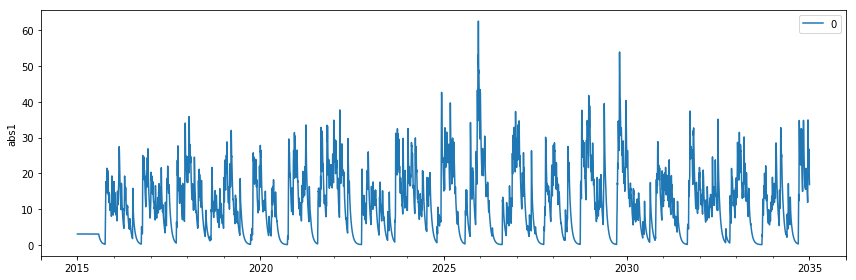

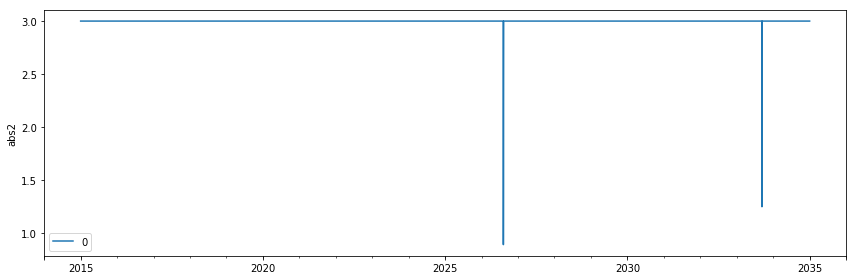

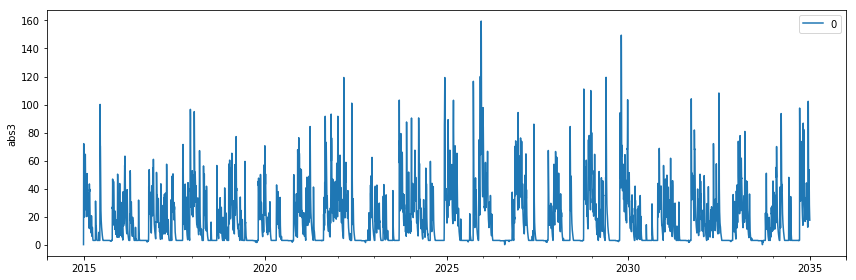

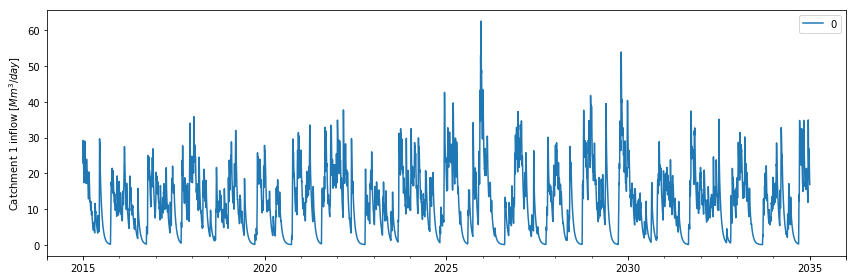

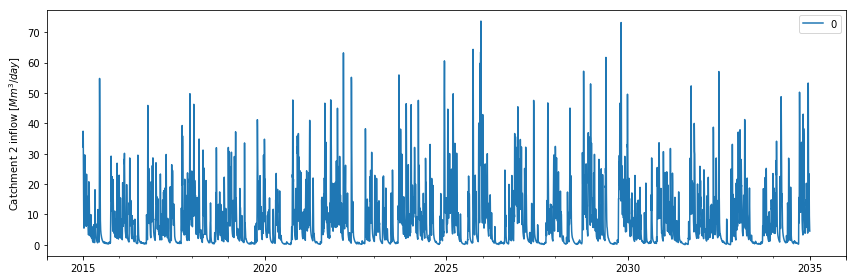

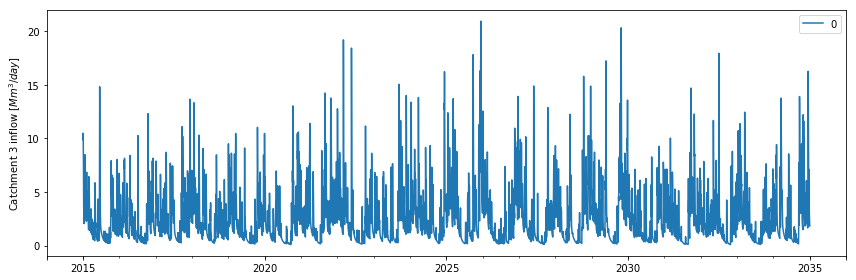

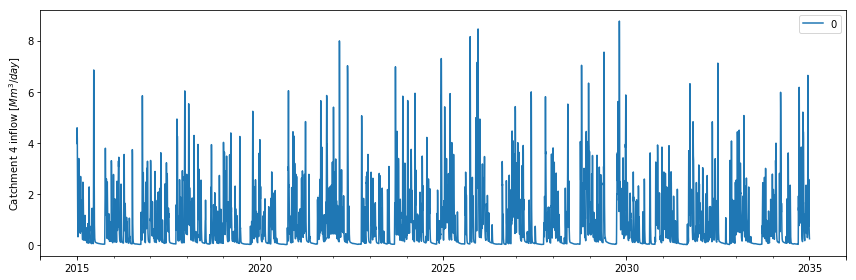

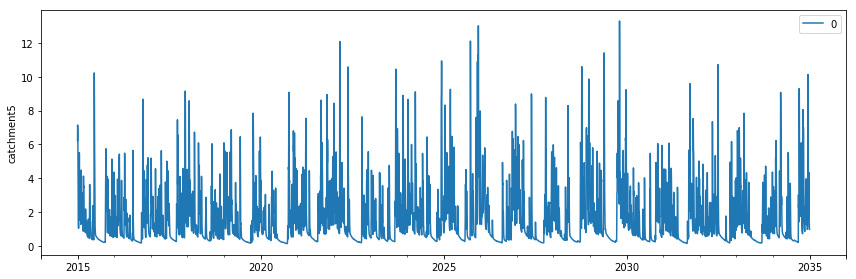

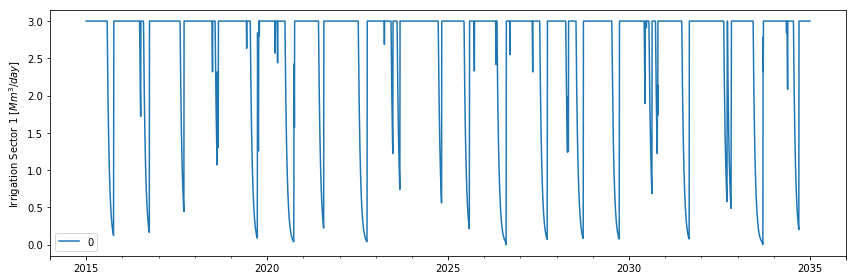

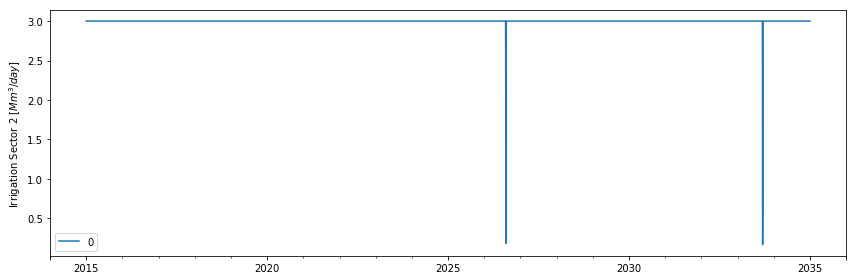

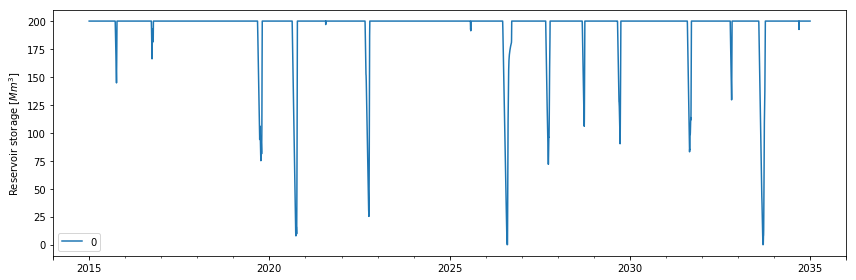

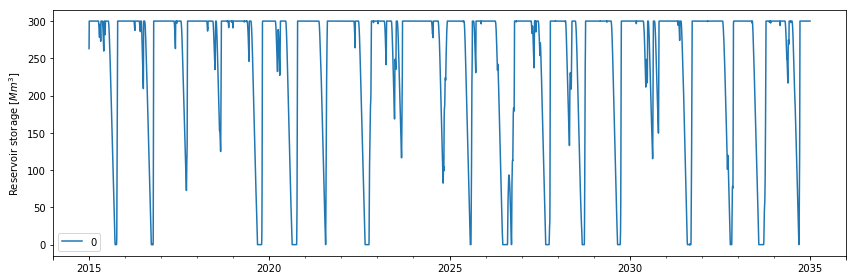

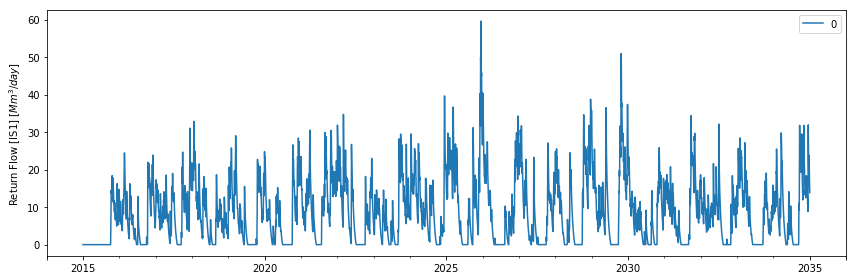

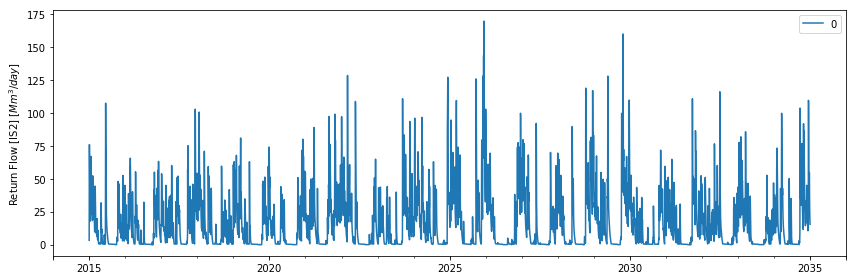

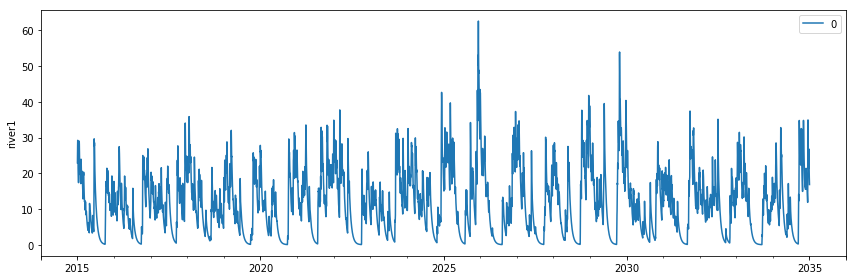

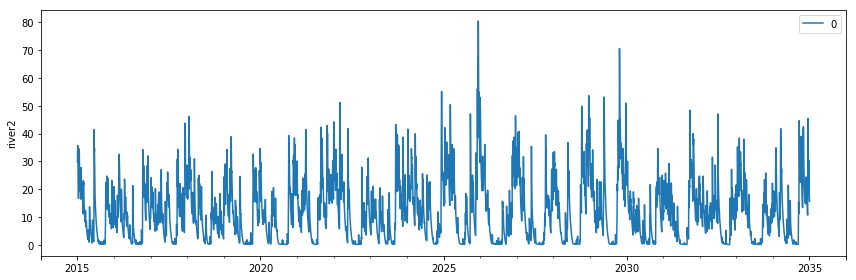

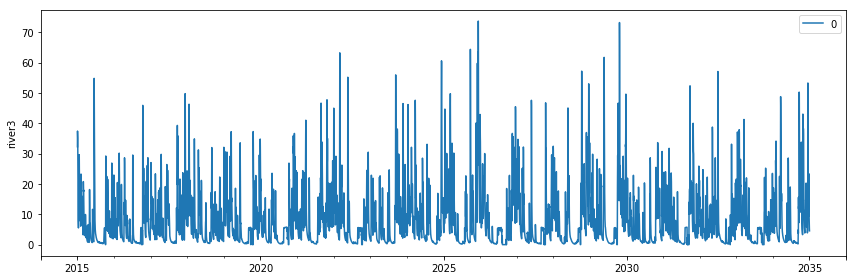

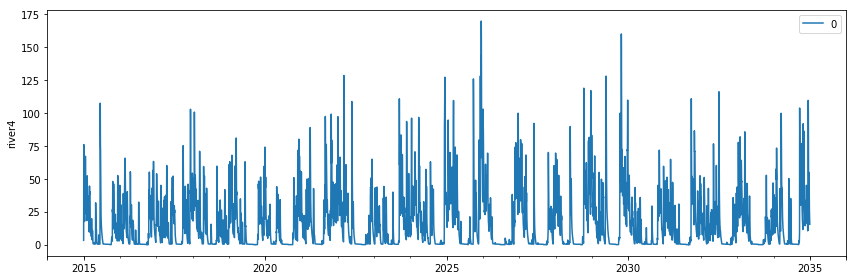

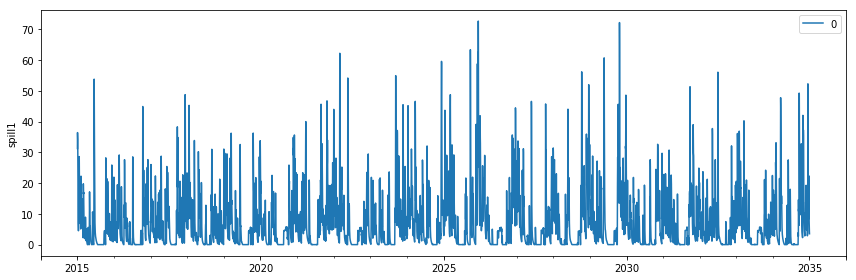

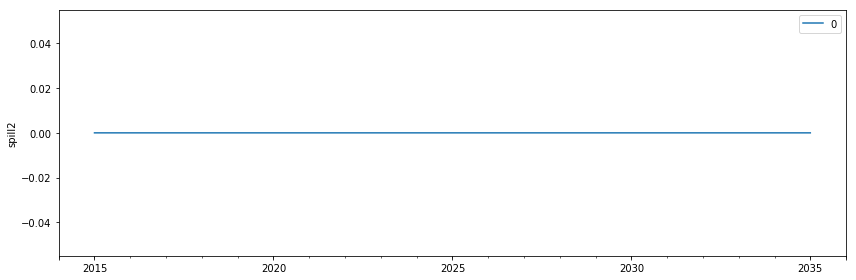

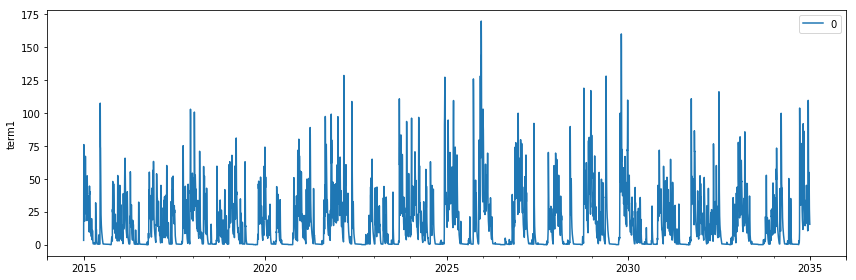

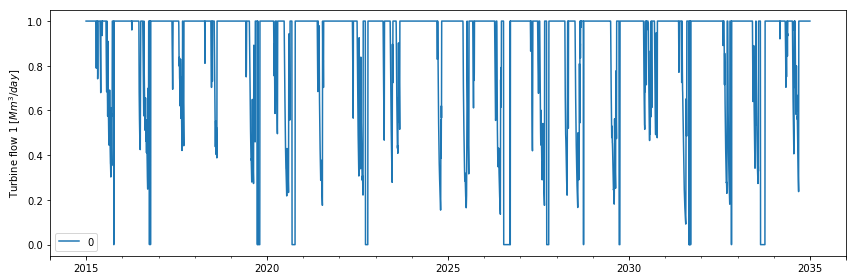

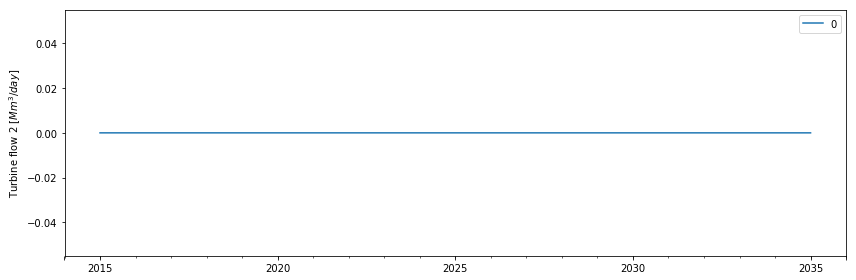

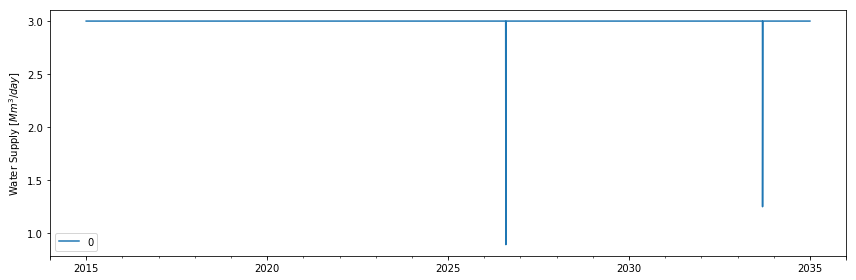

In [6]:


with tables.open_file(os.path.join(OUTPUT_PATH, 'output.h5')) as h5:
    tbl = h5.get_node('/time')
    date_index = pandas.to_datetime({k: tbl.col(k) for k in ('year', 'month', 'day')})
    
    data = {}
    for ca in h5.walk_nodes('/', 'CArray'):
        data[ca._v_name] = pandas.DataFrame(ca.read(), index=date_index, columns=model.scenarios.multiindex)
    
    

#df = pandas.DataFrame(data, index=date_index)

df = pandas.concat(data, axis=1)
nrows = len(df.columns.levels[0])


#df.plot(subplots=True, )
FLOW_UNITS = 'Mm^3'
ENERGY_UNITS = 'MWh' 
PERCENTILES = np.linspace(0, 100)

Y_LABEL_MAP = {
    'catchment1': f'Catchment 1 inflow [${FLOW_UNITS}/day$]',
    'irrigation1': f'Irrigation Sector 1 [${FLOW_UNITS}/day$]',
    'return_flow1': f'Return Flow [IS1] [${FLOW_UNITS}/day$]',
    'catchment2': f'Catchment 2 inflow [${FLOW_UNITS}/day$]',
    'reservoir2': f'Reservoir storage [${FLOW_UNITS}$]',
    'turbine2': f'Turbine flow 2 [${FLOW_UNITS}/day$]',
    'catchment3': f'Catchment 3 inflow [${FLOW_UNITS}/day$]',
    'reservoir1': f'Reservoir storage [${FLOW_UNITS}$]',
    'turbine1': f'Turbine flow 1 [${FLOW_UNITS}/day$]',
    'catchment4': f'Catchment 4 inflow [${FLOW_UNITS}/day$]',
    'irrigation2': f'Irrigation Sector 2 [${FLOW_UNITS}/day$]',
    'return_flow2': f'Return Flow [IS2] [${FLOW_UNITS}/day$]',
    'water_supply1': f'Water Supply [${FLOW_UNITS}/day$]',
    }

for node in df.columns.levels[0]:
    fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
    df[node].plot(ax=ax)
    
    try:
        label = Y_LABEL_MAP[node]
    except KeyError:
        label = node
    
    ax.set_ylabel(label)
    plt.tight_layout()
    fig.savefig(os.path.join(FIG_PATH, f'{node}.png'), dpi=300)
    fig.savefig(os.path.join(FIG_PATH, f'{node}.eps'))
    